# 再チャレンジ

[【GAN + PyTorch】仕組みの解説とMNISTで画像生成 - ころがる狸](https://dajiro.com/entry/2020/05/23/153958)

In [183]:
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [184]:
from torchvision.datasets import MNIST
from torchvision import transforms

mnist = MNIST(
    root='./data',
    train=False,
    transform=transforms.ToTensor(),
    download=True)

X = mnist.data.reshape(-1, 28*28).to(device) / 255
X = X[:1000]
X.shape

torch.Size([1000, 784])

In [185]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(100, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

    def write(self, n):
        noises = torch.randn(n, 100).to(device)
        return self.network(noises)

In [186]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [187]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.network(x)

In [188]:
#generatorの定義
class Generator(nn.Module):
    def __init__(self, input_size = 100, hid1_size = 256,
                 hid2_size = 512, hid3_size = 1024, batch_size = 4):
        super().__init__()
        # self.ngpu = ngpu
        # self.b_size = batch_size
        self.fc1 = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.fc3 = nn.Linear(hid2_size, hid3_size)
        self.fc4 = nn.Linear(hid3_size, 28 * 28 * 1)
    
        self.bn1 = nn.BatchNorm1d(hid1_size)
        self.bn2 = nn.BatchNorm1d(hid2_size)
        self.bn3 = nn.BatchNorm1d(hid3_size)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.LeakyReLU(self.fc1(x))
        x = self.bn1(x)
        x = self.LeakyReLU(self.fc2(x))
        x = self.bn2(x)
        x = self.LeakyReLU(self.fc3(x))
        x = self.bn3(x)
        x = torch.sigmoid(self.fc4(x))
        return x

#discriminatorの定義
class Discriminator(nn.Module):
    def __init__(self, hid1_size = 1024, hid2_size = 512,
                 hid3_size = 256, batch_size = 4):
        super(Discriminator, self).__init__()
        # self.ngpu = ngpu
        # self.b_size = batch_size
        self.fc1 = nn.Linear(784, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.fc3 = nn.Linear(hid2_size, hid3_size)
        self.fc4 = nn.Linear(hid3_size, 1)
    
        self.LeakyReLU = nn.LeakyReLU(0.2)
    
    def forward(self, x):
        x = self.LeakyReLU(self.fc1(x))
        x = self.LeakyReLU(self.fc2(x))
        x = self.LeakyReLU(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [193]:
def train(netD, netG, optimD, optimG, image):
    batch_size = len(image)
    label_real = torch.full((batch_size, 1), 0.)
    label_fake = torch.full((batch_size, 1), 1.)


    y_real = netD(image)
    loss_real = F.binary_cross_entropy(y_real, label_real)
    loss_real.backward(retain_graph=True)

    noise = torch.randn((batch_size, 100))
    fake = netG(noise)
    y_fake = netD(fake)
    loss_fake = F.binary_cross_entropy(y_fake, label_fake)
    loss_fake.backward(retain_graph=True)

    lossD = (loss_real + loss_fake) / 2
    optimD.step()

    y_fake = netD(fake)
    lossG = F.binary_cross_entropy(y_fake, label_real)
    lossG.backward(retain_graph=True)
    optimG.step()


    return lossD, lossG

In [194]:
batch_size = 128
lr = 0.001
dataloader = DataLoader(dataset=mnist, batch_size=batch_size,)

netD = Discriminator()
netG = Generator()
optimD = optim.Adam(netD.parameters(), lr=lr)
optimG = optim.Adam(netG.parameters(), lr=lr)

In [196]:
epochs = 20

In [199]:
for epoch in range(epochs):
    for (image, _) in dataloader:
        # image /= 255.
        optimD.zero_grad()
        optimG.zero_grad()
        lossD, lossG = train(
            netD, netG, optimD, optimG, image.reshape(-1, 784))
    print(f'{epoch+1:>3}epoch lossD:{lossD} lossG:{lossG}')

  1epoch lossD:1.862645149230957e-09 lossG:100.0
  2epoch lossD:1.862645149230957e-09 lossG:100.0
  3epoch lossD:1.862645149230957e-09 lossG:100.0
  4epoch lossD:1.862645149230957e-09 lossG:100.0
  5epoch lossD:1.862645149230957e-09 lossG:100.0
  6epoch lossD:1.862645149230957e-09 lossG:100.0
  7epoch lossD:1.862645149230957e-09 lossG:100.0
  8epoch lossD:1.862645149230957e-09 lossG:100.0
  9epoch lossD:1.862645149230957e-09 lossG:100.0
 10epoch lossD:0.0 lossG:100.0
 11epoch lossD:0.0 lossG:100.0
 12epoch lossD:0.0 lossG:100.0
 13epoch lossD:0.0 lossG:100.0
 14epoch lossD:0.0 lossG:100.0
 15epoch lossD:0.004139489494264126 lossG:100.0
 16epoch lossD:0.0006711593014188111 lossG:100.0
 17epoch lossD:0.019109545275568962 lossG:77.34524536132812
 18epoch lossD:0.0001292107190238312 lossG:67.38507080078125
 19epoch lossD:0.02580072171986103 lossG:77.14562225341797
 20epoch lossD:8.195641498787154e-08 lossG:94.677734375


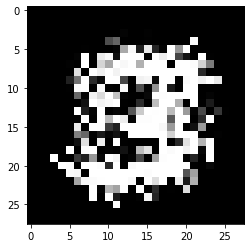

In [198]:
x = torch.randn(10, 100)
img = netG(x)[0].reshape(28, 28).detach().numpy()
plt.imshow(img, cmap="gray");

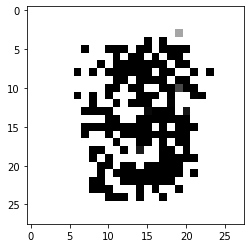

In [215]:
x = torch.randn(10, 100)
img = netG(x)[0].reshape(28, 28).detach().numpy()
plt.imshow(img, cmap="gray");